## Importing libraries
First, I will import necessary libraries and set display settings.

In [ ]:
import pickle
import numpy as np
import collections
import pandas as pd
import datetime as dt
import seaborn as sns

In [ ]:
from sklearn import metrics
from collections import Counter
from scipy.sparse import hstack
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit

In [ ]:
sns.set()

%matplotlib inline

%config InlineBackend.figure_format = 'svg'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Reading, exploring train data and test data

#### Reading train data and test data.

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df = train_df.sort_values(by='time1')

In [ ]:
train_df.head()

session_id  webpage1                time1  webpage2  \
13694       13694       880  2018-01-12 04:00:57     867.0   
34657       34657       880  2018-01-12 04:32:23     867.0   
48835       48835     12450  2018-01-12 04:45:13   12450.0   
71986       71986     12437  2018-01-12 04:45:17   12476.0   
92602       92602     12463  2018-01-12 04:45:20   12502.0   

                     time2  webpage3                time3  webpage4  \
13694  2018-01-12 04:00:57       NaN                  NaN       NaN   
34657  2018-01-12 04:32:23     880.0  2018-01-12 05:02:07     867.0   
48835  2018-01-12 04:45:14   12515.0  2018-01-12 04:45:15   12450.0   
71986  2018-01-12 04:45:17   12489.0  2018-01-12 04:45:18   12476.0   
92602  2018-01-12 04:45:20   12476.0  2018-01-12 04:45:20   12463.0   

                     time4  webpage5  ...                time6  webpage7  \
13694                  NaN       NaN  ...                  NaN       NaN   
34657  2018-01-12 05:02:09       NaN  ...                  NaN       NaN   
48835  2018-01-12 04:45:15   12450.0  ...  2018-01-12 04:45:16   12476.0   
71986  2018-01-12 04:45:18   12437.0  ...  2018-01-12 04:45:18   12463.0   
92602  2018-01-12 04:45:21   12502.0  ...  2018-01-12 04:45:21   12450.0   

                     time7  webpage8                time8  webpage9  \
13694                  NaN       NaN                  NaN       NaN   
34657                  NaN       NaN                  NaN       NaN   
48835  2018-01-12 04:45:16   10344.0  2018-01-12 04:45:16   12489.0   
71986  2018-01-12 04:45:19   12437.0  2018-01-12 04:45:19   12450.0   
92602  2018-01-12 04:45:21   12515.0  2018-01-12 04:45:22   12450.0   

                     time9  webpage10               time10  target  
13694                  NaN        NaN                  NaN       0  
34657                  NaN        NaN                  NaN       0  
48835  2018-01-12 04:45:17    12450.0  2018-01-12 04:45:17       0  
71986  2018-01-12 04:45:19    12450.0  2018-01-12 04:45:20       0  
92602  2018-01-12 04:45:22    12463.0  2018-01-12 04:45:22       0  

[5 rows x 22 columns]

In [ ]:
def information(train_df):
    print(f'Dataset Shape:{train_df.shape}')
    informations = pd.DataFrame(train_df.dtypes, columns=['dtypes'])
    informations = informations.reset_index()
    informations['Name'] = informations['index']
    informations = informations[['Name','dtypes']]
    informations['Missing'] = train_df.isnull().sum().values
    informations['Uniques'] = train_df.nunique().values
    return informations

In [ ]:
information(train_df)

Dataset Shape:(159969, 22)


Name   dtypes  Missing  Uniques
0   session_id    int64        0   159969
1     webpage1    int64        0    11565
2        time1   object        0   149907
3     webpage2  float64     1979    11530
4        time2   object     1979   148183
5     webpage3  float64     3903    11561
6        time3   object     3903   146392
7     webpage4  float64     5567    11553
8        time4   object     5567   144735
9     webpage5  float64     7128    11574
10       time5   object     7128   143262
11    webpage6  float64     8645    11554
12       time6   object     8645   141881
13    webpage7  float64    10057    11534
14       time7   object    10057   140684
15    webpage8  float64    11395    11574
16       time8   object    11395   139465
17    webpage9  float64    12809    11538
18       time9   object    12809   138211
19   webpage10  float64    14113    11509
20      time10   object    14113   137017
21      target    int64        0        2

From here I can see information related to the train dataset. We can see that "site" features have float type, "time" features have object type. Later I will change those types to integer and datetime type. There are also missing values.I can see the same in the following table regarding the test data.

In [ ]:
information(test_df)

Dataset Shape:(93338, 21)


Name   dtypes  Missing  Uniques
0   session_id    int64        0    93338
1     webpage1    int64        0     7678
2        time1   object        0    86584
3     webpage2  float64     1479     7729
4        time2   object     1479    85200
5     webpage3  float64     2732     7677
6        time3   object     2732    84159
7     webpage4  float64     3664     7695
8        time4   object     3664    83240
9     webpage5  float64     4594     7682
10       time5   object     4594    82323
11    webpage6  float64     5409     7668
12       time6   object     5409    81615
13    webpage7  float64     6195     7737
14       time7   object     6195    80961
15    webpage8  float64     6929     7742
16       time8   object     6929    80310
17    webpage9  float64     7653     7654
18       time9   object     7653    79597
19   webpage10  float64     8379     7623
20      time10   object     8379    78952

In [ ]:
site_df = pd.read_parquet('id_map.parquet')

In [ ]:
site_df.head()

id                             webpage
0  326127              www.abmecatronique.com
1  182113                     groups.live.com
2  551820  majeureliguefootball.wordpress.com
3  401995           cdt46.media.tourinsoft.eu
4  105504                 www.hdwallpapers.eu

In [ ]:
print(u'number of all sites:', site_df.id.nunique())

number of all sites: 48371


From here I can see that there are 48371 in this dictionary. Then I'll change the types for "site" and "time" to integer and datetime respectively, but first I will make lists sites and times.

In [ ]:
webpages = [f'webpage{i}' for i in range(1,11)]
times = [f'time{i}' for i in range(1,11)]

In [ ]:
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [ ]:
train_df[webpages] = train_df[webpages].fillna(0).astype('int')
test_df[webpages] = test_df[webpages].fillna(0).astype('int')

I will select 10 of the most popular sites in the whole train dataset.

In [ ]:
webpages_df = pd.melt(train_df, id_vars='target', value_vars=webpages, value_name='webpages')
popular_sites = collections.Counter(webpages_df['webpages']).most_common(10)

In [ ]:
popular_sites

[(425, 80851),
 (0, 75596),
 (451, 59169),
 (438, 38421),
 (529, 35695),
 (2323, 28693),
 (10708, 24969),
 (828, 23438),
 (1192, 23162),
 (7562, 20853)]

In [ ]:
popular_sites.remove((0.0, 75596))

Now I will find the most popular sites for the target column - value 1

In [ ]:
top_websites_of_target = pd.Series(train_df[train_df.target==1][webpages].values.flatten()).value_counts()\
                        .sort_values(ascending = False)[:10]

In [ ]:
site_df.loc[top_websites_of_target]

id                                            webpage
1147  479046                                    www.oopixel.com
973    20276                           planet-terre.ens-lyon.fr
915   575441                       dbffkv15yp72v.cloudfront.net
645   208373                                     fr.adforum.com
627   387097  i1-js-14-3-01-11074-635674841-i.init.cedexis-r...
477   320628                                www.icms.qmul.ac.uk
377   130958                          saintebaume.over-blog.com
304   182620                                      p14.badoo.com
293   206475                                    dl.decoclico.fr
277   434261  i1-js-14-3-01-11074-495066772-i.init.cedexis-r...

### Exploring the time column:

In [ ]:
def plot_time_column():
    plt.figure(figsize=[10, 7])
    plt.subplots_adjust(top=0.88, wspace=0.3, hspace=0.93)
    plt.suptitle('Time column distribution', fontsize=15)
    sns.set_style('darkgrid')
    plt.grid(True)
    plt.subplot(2, 1, 1)
    plt.title('train set', fontsize=13)
    sns.histplot(train_df['time1'], bins=len(train_df['time1'].dt.to_period('M').unique()), color = '#8EB897')
    plt.ylabel('count', fontsize=12)
    plt.xlabel('time1', fontsize=12)
    plt.subplot(2, 1, 2)
    plt.title('test set', fontsize=13)
    sns.histplot(test_df['time1'], bins=len(test_df['time1'].dt.to_period('M').unique()),color = '#8EB897')
    plt.ylabel('count', fontsize=12)
    plt.xlabel('time1', fontsize=12);

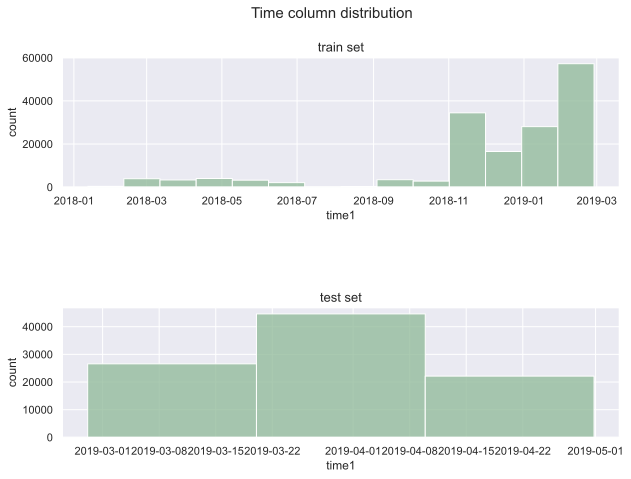

In [ ]:
plot_time_column()

From here I can see that the training and test data are different for the time columns. More below:

In [ ]:
print('************* All days in train dataset by month in column "time1" *************')
print("")
for year in train_df['time1'].dt.year.unique():
    for month in sorted(train_df[(train_df['time1'] > f'{year}-01-01') & (train_df['time1'] < f'{year}-12-31')]['time1'].dt.month.unique()):
        print(f'Year = {year} | Month = {month} | Days = ', sorted(train_df.loc[(train_df['time1'].dt.month==month) & (train_df['time1'].dt.year == year)]['time1'].dt.day.unique()))

************* All days in train dataset by month in column "time1" *************

Year = 2018 | Month = 1 | Days =  [12]
Year = 2018 | Month = 2 | Days =  [12]
Year = 2018 | Month = 3 | Days =  [12]
Year = 2018 | Month = 4 | Days =  [12]
Year = 2018 | Month = 5 | Days =  [12]
Year = 2018 | Month = 6 | Days =  [12]
Year = 2018 | Month = 7 | Days =  [12]
Year = 2018 | Month = 8 | Days =  [12]
Year = 2018 | Month = 9 | Days =  [12]
Year = 2018 | Month = 10 | Days =  [12]
Year = 2018 | Month = 11 | Days =  [12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Year = 2018 | Month = 12 | Days =  [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 31]
Year = 2019 | Month = 1 | Days =  [2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Year = 2019 | Month = 2 | Days =  [1, 2, 3, 4, 5, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [ ]:
print('************* All days in test dataset by month in column "time1" *************')
print('')
for year in test_df['time1'].dt.year.unique():
    for month in sorted(test_df[(test_df['time1'] > f'{year}-01-01') & (test_df['time1'] < f'{year}-12-31')]['time1'].dt.month.unique()):
        print(f'Year = {year} | Month = {month} | Days = ', sorted(test_df.loc[(train_df['time1'].dt.month==month) & (test_df['time1'].dt.year == year)]['time1'].dt.day.unique()))

************* All days in test dataset by month in column "time1" *************

Year = 2019 | Month = 2 | Days =  [2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Year = 2019 | Month = 3 | Days =  [1, 2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Year = 2019 | Month = 4 | Days =  [2, 3, 4, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [ ]:
def correct_dates(df):
    for time in times:
        df_with_column_time = df[time]
        df_with_column_time_corrected = df_with_column_time[df_with_column_time.dt.day <= 12]
        df_with_column_time_corrected = pd.to_datetime(df_with_column_time_corrected.apply(str), format='%Y-%d-%m %H:%M:%S')
        df.loc[df_with_column_time_corrected.index.values, time] = df_with_column_time_corrected
    return df

In [ ]:
train_df = correct_dates(train_df)
test_df = correct_dates(test_df)

In [ ]:
print('All years in train dataset after correction -', train_df['time1'].dt.year.unique())
for year in train_df['time1'].dt.year.unique():
    print(f'All month in train dataset for {year} year after correction -', sorted(train_df[(train_df['time1'] > f'{year}-01-01') & (train_df['time1'] < f'{year}-12-31')]['time1'].dt.month.unique()))
print('All number of months in train dataset after correction -', len(train_df['time1'].dt.to_period('M').unique()))

All years in train dataset after correction - [2018 2019]
All month in train dataset for 2018 year after correction - [11, 12]
All month in train dataset for 2019 year after correction - [1, 2, 3, 4, 5]
All number of months in train dataset after correction - 7


In [ ]:
print('\nAll years in test dataset after correction -', test_df['time1'].dt.year.unique())
for year in test_df['time1'].dt.year.unique():
    print(f'All month in test dataset for {year} year after correction -', sorted(test_df[(test_df['time1'] > f'{year}-01-01') & (test_df['time1'] < f'{year}-12-31')]['time1'].dt.month.unique()))
print('All number of months in test dataset after correction -', len(test_df['time1'].dt.to_period('M').unique()))


All years in test dataset after correction - [2019]
All month in test dataset for 2019 year after correction - [1, 2, 3, 4, 5]
All number of months in test dataset after correction - 5


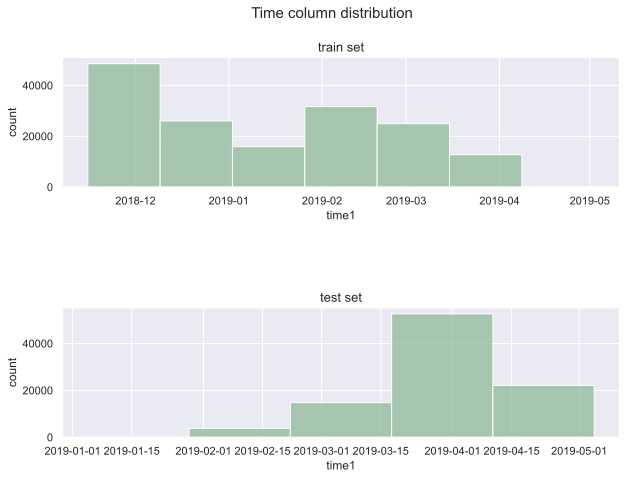

In [ ]:
plot_time_column()

### Exploring the target column

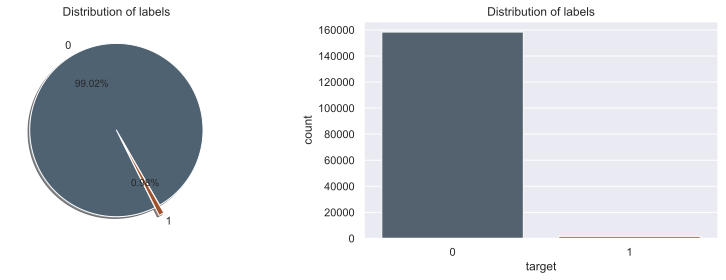

In [ ]:
a , ax = plt.subplots(1,2,figsize=(14,4))
train_df['target'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%',ax=ax[0],shadow=True, startangle=300, colors = ['#4F6272',"sienna"])
ax[0].set_title('Distribution of labels')
ax[0].set_ylabel('')
sns.countplot('target', data = train_df ,ax=ax[1], palette=['#4F6272',"sienna"])
ax[1].set_title('Distribution of labels')
plt.show()

From here we can see that the data is very unbalanced, that there are many more "0" values for the target column than "1" values.

## Feature engineering

Now I will make new features based on the "time" and "webpage" features in order to get more information and to use those features in the model later (session_start, session_end, s_len, weekday, first_hour, end_hour, day, morning, afternoon, evening, night, minute, month, year..).

In [ ]:
def create_new_time_features(df):
    start_hour = df['time1'].apply(lambda ts: ts.hour)
    if 'target' in df.columns:
        df['number_of_sites'] = ((df.notna().sum(axis=1)) / 2) - 1
    else:
        df['number_of_sites'] = ((df.notna().sum(axis=1)) / 2) - 0.5
    df['session_start'] = df[[f"time{i}" for i in range(1,11)]].min(axis=1)
    df['session_end'] = df[[f"time{i}" for i in range(1,11)]].max(axis=1)
    df['s_len'] = (df['session_end'] - df['session_start']).dt.seconds
    df['weekday'] = df['session_start'].dt.dayofweek
    df['first_hour'] = df['session_start'].dt.hour
    df['first_hour'] = df['first_hour'].astype('int')
    df['end_hour'] = df['session_end'].dt.hour
    df['end_hour'] = df['end_hour'].astype('int')
    df['day'] = df['session_start'].dt.day
    df['day'] = df['day'].astype('int')
    df['morning'] = ((start_hour >= 7) & (start_hour < 12)).astype('int').values.reshape(-1, 1)
    df['afternoon'] = ((start_hour >= 12) & (start_hour < 18)).astype('int').values.reshape(-1, 1)
    df['evening'] = ((start_hour >= 18) & (start_hour <= 23)).astype('int').values.reshape(-1, 1)
    df['night'] = ((start_hour >= 0) & (start_hour < 7)).astype('int').values.reshape(-1, 1)
    df['minute'] = df['session_start'].dt.minute
    df['month'] = df['session_start'].dt.month
    df['year'] = df['time1'].apply(lambda x: x.year).astype('int')
    df = df.sort_values('session_start', ignore_index=True)
    df = df.reset_index()
    df = df.rename(columns={'index':'time_index'})
    df = df.sort_values('session_id', ignore_index=True)
    return df

In [ ]:
def sites_dependent_feature(df):
    lst_with_unique_sites_in_sessions = []
    sessions_with_sites = df[webpages].values.tolist()
    for i in range(len(sessions_with_sites)):
        unique_sites_in_session = set(sessions_with_sites[i])
        if 0 in unique_sites_in_session:
            unique_sites_in_session.remove(0)
            lst_with_unique_sites_in_sessions.append(len(unique_sites_in_session))
        else:
            lst_with_unique_sites_in_sessions.append(len(unique_sites_in_session))
    df['number_of_unique_sites'] = np.array(lst_with_unique_sites_in_sessions).reshape(df.shape[0],1)
    return df

In [ ]:
train_df = sites_dependent_feature(train_df)
test_df = sites_dependent_feature(test_df)

In [ ]:
df_train = create_new_time_features(train_df)
df_test= create_new_time_features(test_df)

In [ ]:
df_train.head(2)

time_index  session_id  webpage1               time1  webpage2  \
0      124021           0      9486 2019-02-20 05:57:45         0   
1      129658           1     11722 2019-02-22 07:14:50     12385   

                time2  webpage3               time3  webpage4  \
0                 NaT         0                 NaT         0   
1 2019-02-22 07:14:50     50163 2019-02-22 07:14:51     12385   

                time4  ...  first_hour end_hour  day morning  afternoon  \
0                 NaT  ...           5        5   20       0          0   
1 2019-02-22 07:14:51  ...           7        7   22       1          0   

  evening  night minute  month  year  
0       0      1     57      2  2019  
1       0      0     14      2  2019  

[2 rows x 39 columns]

In [ ]:
df_test.head(2)

time_index  session_id  webpage1               time1  webpage2  \
0       55944           0     10318 2019-03-28 06:47:12     10318   
1        8162           1       438 2019-02-28 06:48:05      2453   

                time2  webpage3               time3  webpage4  \
0 2019-03-28 06:47:42     10318 2019-03-28 06:48:12     10318   
1 2019-02-28 06:50:22      2427 2019-02-28 06:50:22      2466   

                time4  ...  first_hour end_hour  day morning  afternoon  \
0 2019-03-28 06:48:42  ...           6        6   28       0          0   
1 2019-02-28 06:50:23  ...           6        6   28       0          0   

  evening  night minute  month  year  
0       0      1     47      3  2019  
1       0      1     48      2  2019  

[2 rows x 38 columns]

Creation of additional features:

In [ ]:
dct_with_sites_repeat_numbers_for_other = Counter(df_train[df_train['target'] == 0].values.flatten())
number_of_sites_for_other = len(set(df_train[df_train['target'] == 0].values.flatten()))

In [ ]:
dct_with_sites_repeat_numbers_for_target = Counter(df_train[df_train['target'] == 1].values.flatten())
number_of_sites_for_target = len(set(df_train[df_train['target'] == 1].values.flatten()))

In [ ]:
def get_index_popularity(row):
    result = 0
    for site in row:
        sites_index = (dct_with_sites_repeat_numbers_for_other[site]) / number_of_sites_for_other
    result += sites_index
    return result

In [ ]:
def get_target_index_popularity(row):
    result = 0
    for site in row:
        sites_index = (dct_with_sites_repeat_numbers_for_target[site]) / number_of_sites_for_target
    result += sites_index
    return result

In [ ]:
for df in (df_train, df_test):
    df['other_sites_popularity_index'] = df[webpages].apply(get_index_popularity, axis=1)
    df['target_sites_popularity_index'] = df[webpages].apply(get_target_index_popularity, axis=1)

In [ ]:
only_target_sites = set(df_train.query('target == 1')[webpages].values.flatten()) - set(df_train.query('target == 0')[webpages].values.flatten())
only_others_sites = set(df_train.query('target == 0')[webpages].values.flatten()) - set(df_train.query('target == 1')[webpages].values.flatten())

In [ ]:
for df in [df_train, df_test]:
    df['target_sites_belonging'] = df[webpages].apply(lambda x: 1 if len(set(x.values.flatten()) & only_target_sites) >=1 else 0, axis=1)
    df['others_sites_belonging'] = df[webpages].apply(lambda x: 1 if len(set(x.values.flatten()) & only_others_sites) >=1 else 0, axis=1)

## Exploring new features

- In the next chapter, I will explore how different features differ in the behavior of the target in relation to other users. This will help me to create some features that can potentially be useful.

Now I will better research the data through the features I made and show conclusions. First day of week.

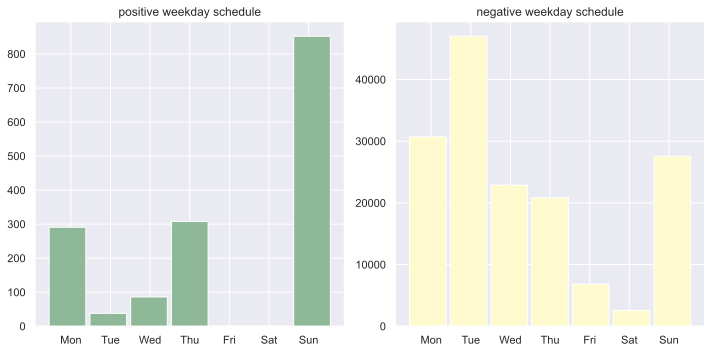

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist(df_train[df_train.target==1].weekday, bins=7, color='#8EB897', label='positive', rwidth=0.9)
ax[1].hist(df_train[df_train.target==0].weekday, bins=7, color='lemonchiffon', label='negative', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('positive weekday schedule')
ax[1].title.set_text('negative weekday schedule')
plt.tight_layout()
plt.show()

If I plot the distributions of weekdays (weekday schedule) I could see that day for target 1 differs from all the others. I have very weak Wednesday, Saturday, and Sunday, and a very strong Monday. Now I will research first_hour feature.

In [ ]:
df_train = pd.get_dummies(df_train, columns=['weekday'])
df_test = pd.get_dummies(df_test, columns=['weekday'])

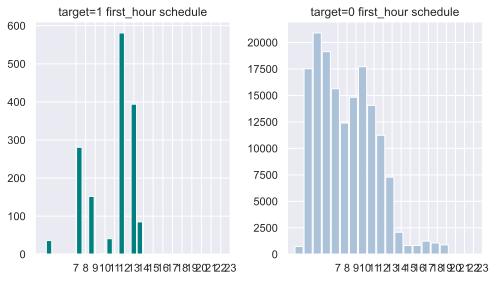

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7,4))
ax[0].hist(df_train[df_train.target==1].first_hour, bins=17, color='teal', label='positive', rwidth=0.9)
ax[1].hist(df_train[df_train.target==0].first_hour, bins=17, color='xkcd:cloudy blue', label='negative', rwidth=0.9)
ax[0].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[1].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[0].title.set_text('target=1 first_hour schedule')
ax[1].title.set_text('target=0 first_hour schedule')
plt.tight_layout()
plt.show()

As I can see, the distributions of hours are really different when target is equal to 1 and when is target equal to 0. I will use this fact. Now, I will research feature session length.

In [ ]:
df_train = pd.get_dummies(df_train, columns=['first_hour'])
df_test = pd.get_dummies(df_test, columns=['first_hour'])

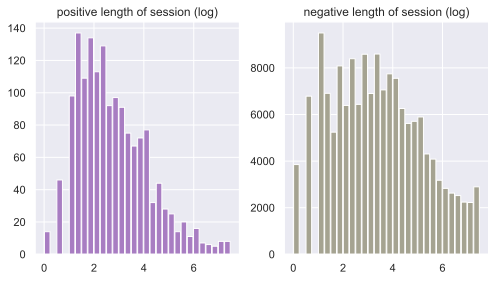

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7,4))
ax[0].hist(np.log(df_train[df_train.target==1].s_len + 1), bins=30, color='xkcd:wisteria', label='positive', rwidth=0.9)
ax[1].hist(np.log(df_train[df_train.target==0].s_len + 1), bins=30, color='xkcd:cement', label='negative', rwidth=0.9)
ax[0].title.set_text('positive length of session (log)')
ax[1].title.set_text('negative length of session (log)')
plt.tight_layout()
plt.show()

You can see a noticeable but not big difference in distribution. I decided to use this feature.

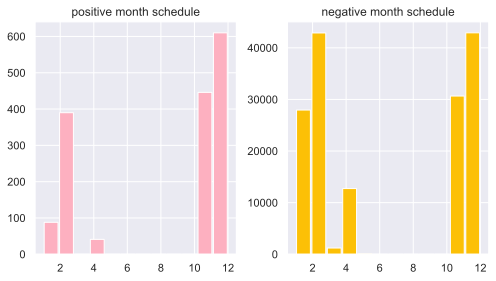

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7,4))
ax[0].hist(df_train[df_train.target==1].month, bins=12, color='xkcd:soft pink', label='positive', rwidth=0.9)
ax[1].hist(df_train[df_train.target==0].month, bins=12, color='xkcd:marigold', label='negative', rwidth=0.9)
ax[0].title.set_text('positive month schedule')
ax[1].title.set_text('negative month schedule')
plt.tight_layout()
plt.show()

I can see from the months that in the period from the fifth to the 8th month of the year, the distribution when target=1 is 0, in the case when target = 0 it is very similar, but there are differences

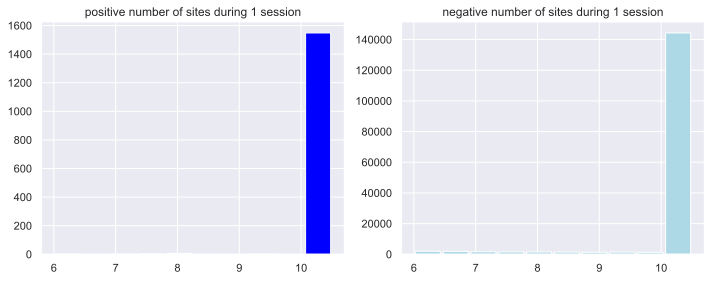

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(df_train[df_train.target==1].number_of_sites, bins=10, color='blue', label='positive', rwidth=0.9)
ax[1].hist(df_train[df_train.target==0].number_of_sites, bins=10, color='lightblue', label='negative', rwidth=0.9)
ax[0].title.set_text('positive number of sites during 1 session')
ax[1].title.set_text('negative number of sites during 1 session')
plt.tight_layout()
plt.show()

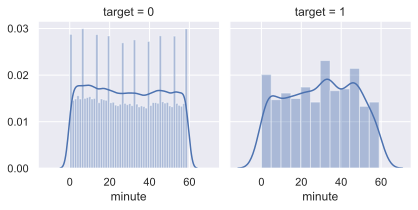

In [ ]:
g = sns.FacetGrid(df_train, col="target")
g.map(sns.distplot, 'minute')


let's check how specific the target is to other users - by session length, for example

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='target', y='s_len', data=df_train)
ses_dur_for_other_user = df_train.query('target == 0')['s_len'].mean()
ses_der_for_alice = df_train.query('target == 1')['s_len'].mean()
plt.legend(handles=[Patch(color='blue', alpha=.5, label=f'Other (Mean time session duration - {ses_dur_for_other_user:.2f})'),
                    Patch(color='orange', alpha=.5, label=f'Target (Mean time session duration - {ses_der_for_alice:.2f})')],
           loc='center',
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.25))
plt.show(True);

In [ ]:
for df in [df_train, df_test]:
    df['session_duration_category'] = df[webpages].apply(lambda x:1 if ((~np.isin(x, ['empty'])).sum() < 140) else 0, axis=1)

In [ ]:
corr_data = df_train.drop(times, axis=1)
corr_data.drop(webpages, axis=1, inplace=True)

In [ ]:
corr_data.columns

Index(['time_index', 'session_id', 'target', 'number_of_unique_sites',
       'number_of_sites', 'session_start', 'session_end', 's_len', 'end_hour',
       'day', 'morning', 'afternoon', 'evening', 'night', 'minute', 'month',
       'year', 'other_sites_popularity_index', 'target_sites_popularity_index',
       'target_sites_belonging', 'others_sites_belonging', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'first_hour_3', 'first_hour_4', 'first_hour_5',
       'first_hour_6', 'first_hour_7', 'first_hour_8', 'first_hour_9',
       'first_hour_10', 'first_hour_11', 'first_hour_12', 'first_hour_13',
       'first_hour_14', 'first_hour_15', 'first_hour_16', 'first_hour_17',
       'first_hour_18', 'first_hour_19', 'session_duration_category'],
      dtype='object')

### Correlation matrix

Now, I will check correlation between features.

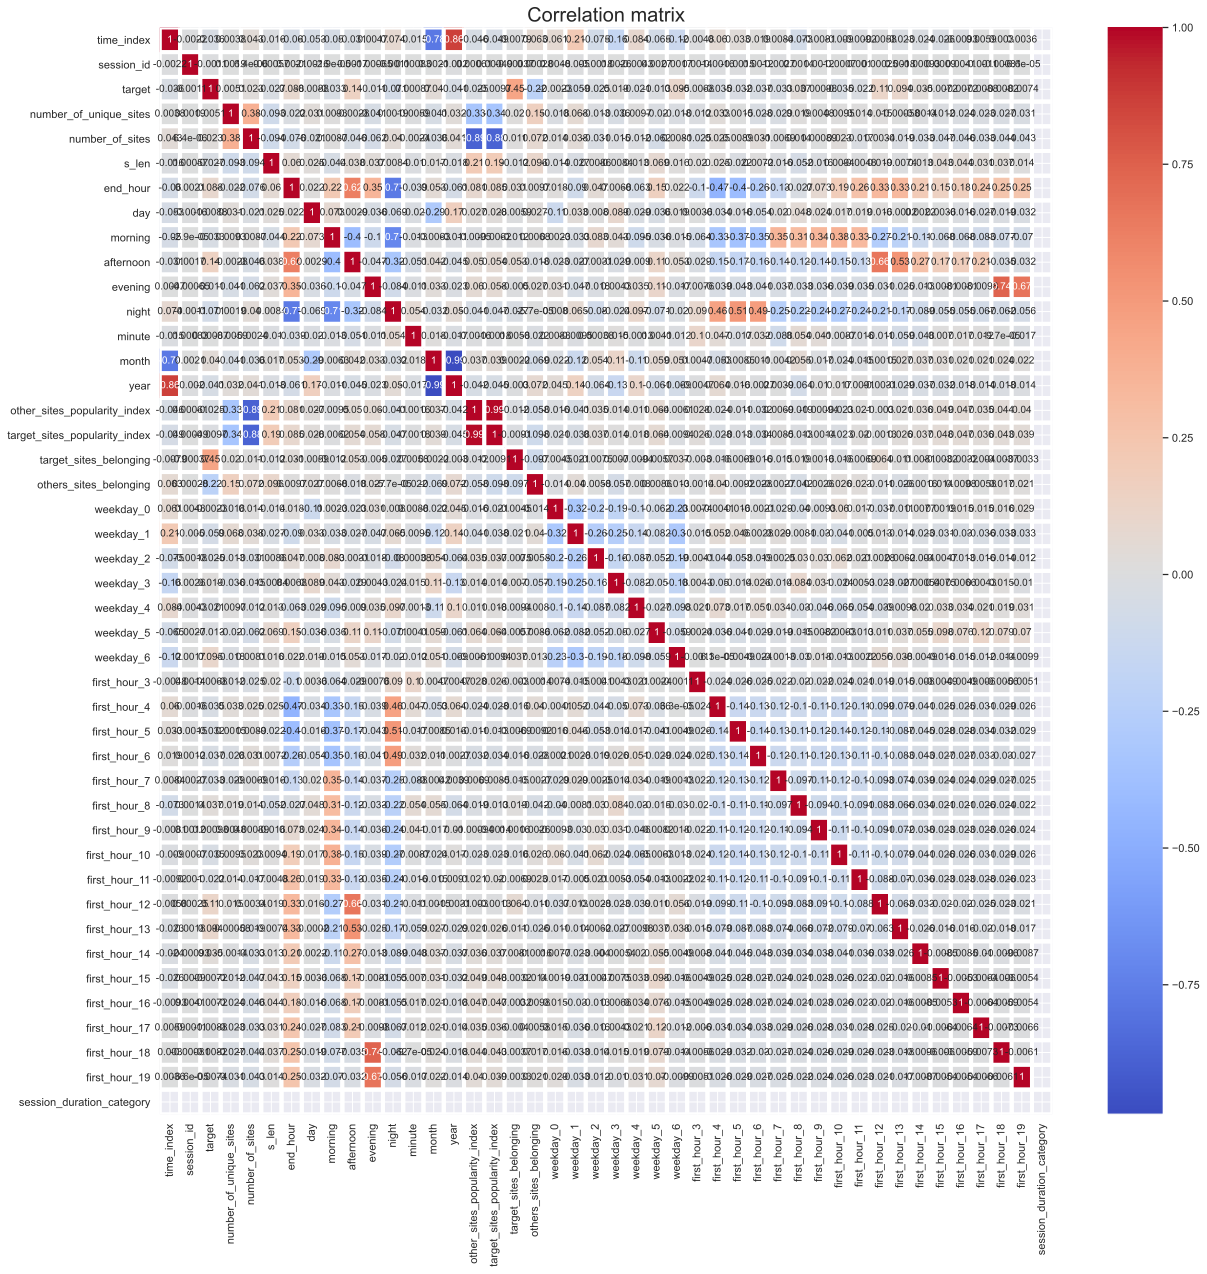

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Correlation matrix', fontsize=20)
sns.heatmap(corr_data.corr(), annot=True, cmap="coolwarm",  fmt='.2g', linewidth=4)
plt.grid(True);

I can see that the correlation with the other features is equal to zero, so I will drop the features "night" and "session_duration_category" from train dataframe and test dataframe.

In [ ]:
corr_data = corr_data.drop(["night", "session_duration_category"], axis=1)

In [ ]:
df_train = df_train.drop(["night", "session_duration_category"], axis=1)
df_test = df_test.drop(["night", "session_duration_category"], axis=1)

### TfidfVectorizer

TF-IDF Vectorizer is a measure of originality of a word by comparing the number of times a word appears in a document with the number of documents the word appears in, so it's a good way to treat sites as strings and track the frequency of occurrence and to make additional features.

In [ ]:
vect = TfidfVectorizer(ngram_range=(1,5),
                       tokenizer=lambda s: s.split(),
                       max_features=50000)

In [ ]:
train_site_matrix = df_train[webpages].astype('str').to_numpy().tolist()
train_site_matrix = [' '.join(sublist) for sublist in train_site_matrix]
train_site_matrix = vect.fit_transform(train_site_matrix)

In [ ]:
print('Train site matrix')
pd.DataFrame(data = train_site_matrix.toarray(), columns = vect.get_feature_names()).T.head(3)

Train site matrix


0       1       2       3       4       5       6       7       \
0      0.505573     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0 0    0.462108     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0 0 0  0.417762     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       8       9       ...  159959  159960  159961  159962  159963  159964  \
0         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
0 0       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
0 0 0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

       159965  159966    159967  159968  
0         0.0     0.0  0.360166     0.0  
0 0       0.0     0.0  0.296281     0.0  
0 0 0     0.0     0.0  0.229585     0.0  

[3 rows x 159969 columns]

In [ ]:
test_site_matrix = df_test[webpages].astype('str').to_numpy().tolist()
test_site_matrix = [' '.join(sublist) for sublist in test_site_matrix]
test_site_matrix = vect.transform(test_site_matrix)

In [ ]:
print('Test site matrix')
pd.DataFrame(data = test_site_matrix.toarray(), columns = vect.get_feature_names()).T.head(3)

Test site matrix


0      1         2      3      4      5      6      7      8      \
0        0.0    0.0  0.426558    0.0    0.0    0.0    0.0    0.0    0.0   
0 0      0.0    0.0  0.350897    0.0    0.0    0.0    0.0    0.0    0.0   
0 0 0    0.0    0.0  0.271906    0.0    0.0    0.0    0.0    0.0    0.0   

          9      ...  93328  93329  93330  93331     93332  93333  93334  \
0      0.393597  ...    0.0    0.0    0.0    0.0  0.038236    0.0    0.0   
0 0    0.269819  ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0   
0 0 0  0.139386  ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0   

          93335  93336  93337  
0      0.052119    0.0    0.0  
0 0    0.000000    0.0    0.0  
0 0 0  0.000000    0.0    0.0  

[3 rows x 93338 columns]

### Scaling data

In [ ]:
features = corr_data.columns

In [ ]:
df_train = df_train.drop(times, axis=1)
df_train.drop(webpages, axis=1, inplace=True)
df_test= df_test.drop(times, axis=1)
df_test.drop(webpages, axis=1, inplace=True)

In [ ]:
scaler = StandardScaler()
for column in df_train.drop('target', axis=1).columns.tolist():
    df_train[column] = scaler.fit_transform(df_train[column].values.reshape(-1, 1))
for column in df_test.columns.tolist():
    df_test[column] = scaler.fit_transform(df_test[column].values.reshape(-1, 1))

In [ ]:
df_train.head(2)

time_index  session_id  target  number_of_unique_sites  number_of_sites  \
0    0.953614   -1.732040       0               -1.976840        -5.001815   
1    1.075682   -1.732018       0                0.518362         0.277187   

   session_start  session_end     s_len  end_hour       day  ...  \
0       0.908273     0.908236 -0.465043 -1.032387  0.365740  ...   
1       0.956978     0.956948 -0.378470 -0.410427  0.594565  ...   

   first_hour_11  first_hour_12  first_hour_13  first_hour_14  first_hour_15  \
0      -0.310917      -0.282462      -0.224583      -0.117185      -0.072524   
1      -0.310917      -0.282462      -0.224583      -0.117185      -0.072524   

   first_hour_16  first_hour_17  first_hour_18  first_hour_19  \
0      -0.072437      -0.088529      -0.082137      -0.074544   
1      -0.072437      -0.088529      -0.082137      -0.074544   

   session_duration_category  
0                        0.0  
1                        0.0  

[2 rows x 45 columns]

Now, I will split data.

In [ ]:
X_train = df_train.drop(['target'], axis=1).fillna(0).astype('int')
y_train = df_train.target.astype('int')
X_test = df_test.fillna(0).astype('int')

X_train.shape, X_test.shape, y_train.shape

((159969, 44), (93338, 44), (159969,))

In [ ]:
X_train.info()
print('-' * 45)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159969 entries, 0 to 159968
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   time_index                     159969 non-null  int64
 1   session_id                     159969 non-null  int64
 2   number_of_unique_sites         159969 non-null  int64
 3   number_of_sites                159969 non-null  int64
 4   session_start                  159969 non-null  int64
 5   session_end                    159969 non-null  int64
 6   s_len                          159969 non-null  int64
 7   end_hour                       159969 non-null  int64
 8   day                            159969 non-null  int64
 9   morning                        159969 non-null  int64
 10  afternoon                      159969 non-null  int64
 11  evening                        159969 non-null  int64
 12  minute                         159969 non-null  int64
 13 

I will use hstack to combine all features that I will use for modelling.

In [ ]:
X_train=hstack([train_site_matrix, X_train])
X_test=hstack([test_site_matrix, X_test])

In [ ]:
final_test = X_test

In [ ]:
X_train_whole, y_train_whole = X_train, y_train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

TimeSeriesSplit - provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.

In [ ]:
ts_cv = TimeSeriesSplit(n_splits = 5)

### Grid search

In [ ]:
def grid_search(model, grid):
    gs=GridSearchCV(model, grid, cv=10)
    gs.fit(X_train, y_train)
    return gs

In [ ]:
def print_gs_eval(gs):
    # best score achieved during the GridSearchCV
    print('GridSearch CV best score: {:.4f}\n'.format(gs.best_score_))

    # print parameters that give the best results
    print('Parameters that give the best results:', (gs.best_params_))

    # print estimator that was chosen by the GridSearch
    print('\nEstimator that was chosen by the search:', (gs.best_estimator_))

In [ ]:
grid={'n_estimators': [100, 300, 500],
     'n_jobs': [-1]}
model=RandomForestClassifier()

In [ ]:
gs=grid_search(model, grid)

In [ ]:
print_gs_eval(gs)

GridSearch CV best score: 0.9947

Parameters that give the best results: {'n_estimators': 500, 'n_jobs': -1}

Estimator that was chosen by the search: RandomForestClassifier(n_estimators=500, n_jobs=-1)


In [ ]:
grid = {'penalty' : ['l1', 'l2'],
    'C' : [0.1, 1, 10, 100]}
model = LogisticRegression()

In [ ]:
gs=grid_search(model, grid)

In [ ]:
print_gs_eval(gs)

GridSearch CV best score: 0.9958

Parameters that give the best results: {'C': 10, 'penalty': 'l2'}

Estimator that was chosen by the search: LogisticRegression(C=10)


Now I will use the parameters obtained by the grid search to initialize the model.

### Metrics calculation

In this section, I will initialize the model and calculate the basic metrics for each model.

In [ ]:
models = {
    RandomForestClassifier(random_state = 42, n_jobs=-1, n_estimators = 500): 'Random Forest Classifier',
    LogisticRegression(random_state = 42, C=10, penalty='l2'): 'Logistic Regression'
}

for m in models.keys():
    m.fit(X_train, y_train)

for model,name in models.items():
     print(f"Accuracy Score for {name} is : ", model.score(X_test, y_test)*100,"%")

Accuracy Score for Random Forest Classifier is :  99.381133962618 %
Accuracy Score for Logistic Regression is :  99.50615740451335 %


In [ ]:
for model, name in models.items():
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}")
    print("----------------------------------------------------------")
    print(classification_report(y_test, y_pred))
    print("----------------------------------------------------------")

Classification Report for Random Forest Classifier
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31653
           1       1.00      0.42      0.59       341

    accuracy                           0.99     31994
   macro avg       1.00      0.71      0.79     31994
weighted avg       0.99      0.99      0.99     31994

----------------------------------------------------------
Classification Report for Logistic Regression
----------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31653
           1       0.86      0.64      0.73       341

    accuracy                           1.00     31994
   macro avg       0.93      0.82      0.87     31994
weighted avg       0.99      1.00      0.99     31994

----------------------------------------------------------


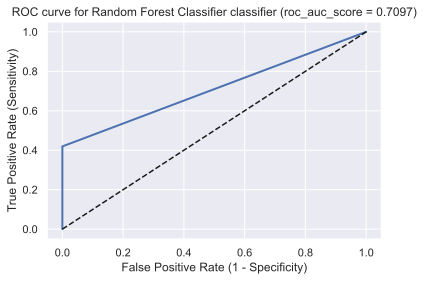

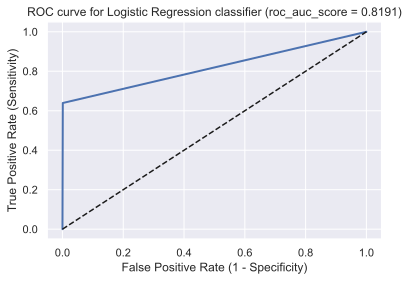

In [ ]:
for model, name in models.items():
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title(f'ROC curve for {name} classifier (roc_auc_score = {round(metrics.roc_auc_score(y_test, y_pred), 4)})')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    print(" ")

#### Check for overfitting and underfitting

In [ ]:
for model,name in models.items():
    y_pred = model.predict(X_train)
    print(f"Training set score for {name}")
    print(model.score(X_train, y_train))
    print(" ")
    print(f"Test set score for {name}")
    print(model.score(X_test, y_test))
    print("----------------------------------------------------------")
    print(" ")

Training set score for Random Forest Classifier
0.999968743895292
 
Test set score for Random Forest Classifier
0.99381133962618
----------------------------------------------------------
 
Training set score for Logistic Regression
0.9977495604610276
 
Test set score for Logistic Regression
0.9950615740451335
----------------------------------------------------------
 


### Whole dataset check

In [ ]:
%%time
clf_lr = LogisticRegression(random_state = 42, C=10, penalty='l2')
clf_lr.fit(X_train, y_train)
preds_lr = clf_lr.predict_proba(X_test)[:, 1]
print ('Train test split LogisticRegression score:% s ROC AUC'% round(metrics.roc_auc_score(y_test, preds_lr), 4))
cross_score_lr = np.mean(cross_val_score(clf_lr, X_train_whole, y_train_whole, scoring='roc_auc', cv=ts_cv))
print ('Cross validation LogisticRegression score:% s ROC AUC'% round(cross_score_lr, 4))

Train test split LogisticRegression score:0.9969 ROC AUC
Cross validation LogisticRegression score:0.9954 ROC AUC
CPU times: user 1min 13s, sys: 47.5 s, total: 2min 1s
Wall time: 12.2 s


In [ ]:
%%time
clf_rf = RandomForestClassifier(random_state = 42, n_jobs=-1, n_estimators = 500)
clf_rf.fit(X_train, y_train)
preds_rf = clf_rf.predict_proba(X_test)[:, 1]
print ('Train test split RandomForestClassifier score:% s ROC AUC'% round (metrics.roc_auc_score(y_test, preds_rf), 4))
cross_score_rf = np.mean(cross_val_score (clf_rf, X_train_whole, y_train_whole, scoring = 'roc_auc', cv=ts_cv))
print ('Cross validation RandomForestClassifier score:% s ROC AUC'% round (cross_score_rf, 4))

Train test split RandomForestClassifier score:0.9946 ROC AUC


Based on the obtained metrics, I will apply LogisticRegression model the prediction model on the test set.

In [ ]:
predictions = clf_lr.predict(final_test)

In [ ]:
output = pd.DataFrame({'session_id': test_df.session_id,
                      'target': predictions})

In [ ]:
output